# Trabajo 2: Aspectos prácticos de las redes neuronales

**Nombre:** Kevin Fabricio Calle Urgilez

**Asignatura:** Sistemas Cognitivos Artificiales 

**Fecha:** 29/10/18

En este segundo trabajo, vamos a continuar desarrollando el problema de Fashion MNIST, con el objetivo de entender los aspectos prácticos del entrenamiento de redes neuronales que hemos visto en el Tema 4.

El código utilizado para contestar tiene que quedar claramente reflejado en el Notebook. Puedes crear nuevas cells si así lo deseas para estructurar tu código y sus salidas. A la hora de entregar el notebook, **asegúrate de que los resultados de ejecutar tu código han quedado guardados**. 

In [1]:
# Puedes añadir todos los imports adicionales que necesites aquí

import keras
from keras import optimizers
from keras import regularizers
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

Using TensorFlow backend.


#### Obtención de los datos y pre-processing

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

## Consideraciones iniciales

### Train-validation-test split

En todos los modelos que entrenemos, vamos a partir los datos de training (x_train) en dos sets: training y validación. De este modo, al final tendremos tres datasets distintos: training, validation, y test. Esta es una estrategia común en el aprendizaje automático, en la que los datos de test (o held-out data) se 
"esconden" hasta el final. Los datos de validación se utilizan para estimar cómo de bien están funcionando nuestros modelos y para observar si estamos cayendo en overfitting. Esto nos permite cambiar hiperparámetros y probar distintas arquitecturas **sabiendo que no estamos utilizando información del test set para "optimizar" los resultados en éste** (si eligiéramos nuestro mejor modelo en base a los resultados de test, estaríamos "haciendo trampas", ya que se ha utilizado la información contenida en éste para elegir el modelo y las métricas reportadas serían optimistas).

Para utilizar un split training-validation data durante el entrenamiento, podemos partir nosotros mismos los datos o dejar que Keras lo haga. Podéis ver cómo hacer estas particiones en la documentación de *fit*.

#### **Requisito: En todos los entrenamientos de esta práctica, se requiere utilizar el 20% de los datos en x_train como  conjunto de datos de validación **

### Un error común con modelos de Keras

En esta práctica entrenaremos varios modelos para comparar resultados. Un error común en Keras es no instanciar un nuevo modelo cada vez que hacemos un nuevo entrenamiento. Al hacer

*model = Sequential()*

*model.add(lo que sea)  # Definición del modelo*

*model.fit()*

si queremos entrenar un nuevo modelo o el mismo modelo otra vez, es necesario volver a inicializar el modelo con model = Sequential(). Si olvidamos este paso y volvemos a hacer fit(), el modelo seguirá entrenando por donde se quedó en el último fit().

### Análisis de resultados 

A la hora de escribir las respuestas y los análisis pedidos, es importante presentar las conclusiones de manera adecuada a partir de lo visto en nuestros experimentos. Los Jupyter Notebook son una herramienta imprescindible para *data scientists* e ingenieros de Machine Learning para presentar los resultados, incluyendo soporte para incluir gráficas y elementos visuales. Podéis explicar vuestras observaciones del modo que consideréis adecuado, si bien recomendamos la utilización de gráficas para evaluar los entrenamientos y comparar resultados.

Como ayuda, las siguientes funciones pueden resultar interesantes a la hora de evaluar resultados. Todas ellas utilizan el objeto *history* que podéis obtener como salida del método *fit()* de Keras:

history = model.fit(x_train, y_train, ...)

Por supuesto, podéis modificarlas y utilizarlas como prefiráis para crear vuestros propios informes.

In [3]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()
    
# Nota: podéis cambiar los números aquí presentes y ejecutar esta línea si queréis cambiar el tamaño
# de las gráficas
# matplotlib.rcParams['figure.figsize'] = [8, 8]


## 1. Unidades de activación

En este ejercicio, vamos a evaluar la importancia de utilizar las unidades de activación adecuadas. Como hemos visto en clase, funciones de activación como sigmoid han dejado de utilizarse en favor de otras unidades como ReLU.

**Ejercicio 1**: Partiendo de una red sencilla como la desarrollada en el Trabajo 1, escribir un breve análisis comparando la utilización de unidades sigmoid y ReLU (por ejemplo, se pueden comentar aspectos como velocidad de convergencia, métricas obtenidas...). Explicar por qué pueden darse estas diferencias. Opcionalmente, comparar con otras activaciones disponibles en Keras.

*Pista: Usando redes más grandes se hace más sencillo apreciar las diferencias. Es mejor utilizar al menos 3 o 4 capas densas.*

# Tamaño de los conjuntos: train, validation y test

En esta sección se muestra el tamaño que tienen los conjuntos train, validation y test formados en cada modelo. Es importante aclarar que aquí solo se muestran sus dimensiones ya que en los modelos entrenados a cotinuación se usó la función "fit.model(validation_split=0.2)" para usar el 20% de los datos de train como datos de validación.

In [4]:
# Imprimimos en pantalla las dimensiones de los arrays "train?size", "validation_size" y "test_size"

train_size = x_train.shape[0] - (x_train.shape[0] * 0.20)
validation_size = x_train.shape[0] * 0.20
test_size = x_test.shape[0] 

print("Dimensión del conjunto de train: " + str(train_size))
print("Dimensión del conjunto validation: " + str(validation_size))
print("Dimensión del conjunto de test: " + str(test_size))

Dimensión del conjunto de train: 48000.0
Dimensión del conjunto validation: 12000.0
Dimensión del conjunto de test: 10000


# Primer modelo con unidades de activación "sigmoid"

En este modelo se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí el principal parámetro a probar es el rendimiento de la unidad de activación sigmoidea. Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes unidades de activación.

In [5]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [6]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 30

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación sigmoideas
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, activation = 'sigmoid', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
__________

In [7]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)

sgd = optimizers.SGD(lr=0.09, decay=1e-6, momentum=0.0, nesterov=True)

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_unidad_sigmoid = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2
         )

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 5s 100us/step - loss: 2.3327 - acc: 0.1043 - val_loss: 2.3052 - val_acc: 0.0958
Epoch 2/30
48000/48000 [==============================] - 4s 90us/step - loss: 2.3108 - acc: 0.1043 - val_loss: 2.3014 - val_acc: 0.0958
Epoch 3/30
48000/48000 [==============================] - 4s 91us/step - loss: 2.2951 - acc: 0.1176 - val_loss: 2.2537 - val_acc: 0.2005
Epoch 4/30
48000/48000 [==============================] - 4s 87us/step - loss: 1.8638 - acc: 0.2353 - val_loss: 1.4939 - val_acc: 0.3492
Epoch 5/30
48000/48000 [==============================] - 4s 87us/step - loss: 1.4177 - acc: 0.3825 - val_loss: 1.2122 - val_acc: 0.4874
Epoch 6/30
48000/48000 [==============================] - 4s 87us/step - loss: 1.2421 - acc: 0.4580 - val_loss: 1.0806 - val_acc: 0.5432
Epoch 7/30
48000/48000 [==============================] - 4s 92us/step - loss: 1.1080 - acc: 0.5407 - val_loss: 0.9035 - val_ac

### Observaciones

En este modelo utilizando función de activación sigmoid observamos que no se cae en overfitting y se llega a tener una precisión del 82% en 30 épocas. Según el comportamiento del gráfico de precisión vemos que se puede llegar a mejorar este valor sin caer en sobreajuste de datos. Sin embargo solo representaremos 30 épocas para compararlo con otras unidades de activación más adelante. En el gráfico del error se observa igualamente que en el conjunto de validación se puede disminuir aún más este error sin caer en sobreajuste.

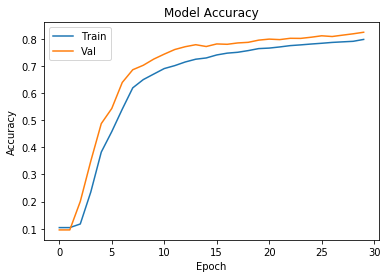

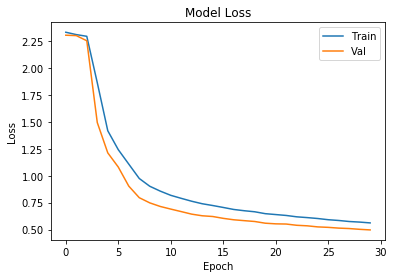

In [8]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_unidad_sigmoid)

plot_loss(history_unidad_sigmoid)

# Segundo modelo con unidades de activación "ReLU"

En este modelo se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí el principal parámetro a probar es el rendimiento de la unidad de activación ReLU. Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes unidades de activación.

In [9]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [10]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 30

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
__________

In [11]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)

sgd = optimizers.SGD(lr=0.09, decay=1e-6, momentum=0.0, nesterov=True)

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_unidad_relu = model.fit(x_train, y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_split=0.2
                                 )

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 5s 112us/step - loss: 0.8276 - acc: 0.6920 - val_loss: 0.4798 - val_acc: 0.8227
Epoch 2/30
48000/48000 [==============================] - 5s 100us/step - loss: 0.5406 - acc: 0.8078 - val_loss: 0.4445 - val_acc: 0.8385
Epoch 3/30
48000/48000 [==============================] - 5s 98us/step - loss: 0.4842 - acc: 0.8273 - val_loss: 0.4074 - val_acc: 0.8527
Epoch 4/30
48000/48000 [==============================] - 5s 103us/step - loss: 0.4529 - acc: 0.8389 - val_loss: 0.4005 - val_acc: 0.8604
Epoch 5/30
48000/48000 [==============================] - 5s 111us/step - loss: 0.4304 - acc: 0.8475 - val_loss: 0.3798 - val_acc: 0.8642
Epoch 6/30
48000/48000 [==============================] - 5s 98us/step - loss: 0.4110 - acc: 0.8521 - val_loss: 0.3778 - val_acc: 0.8633
Epoch 7/30
48000/48000 [==============================] - 5s 104us/step - loss: 0.4005 - acc: 0.8571 - val_loss: 0.3660 - va

### Observaciones

En este modelo utilizando función de activación ReLU, observamos que se llega a tener una precisión del 88.5% en 30 épocas. Sin embargo, vemos que en el  gráfico de precisión caemos en overfitting aproximadamente desde la época 15. Por lo tanto, vemos que en este modelo hay que cuidar mucho el valor del learning rate puesto que aprende mucho más rápido y puede caer en overfitting más rápido también.

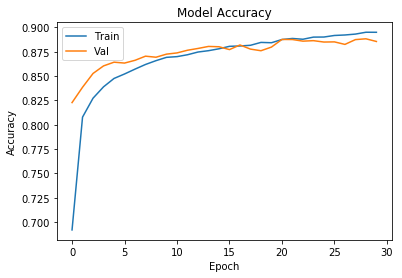

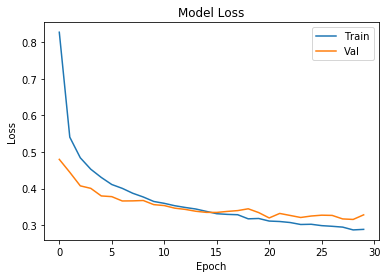

In [12]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_unidad_relu)

plot_loss(history_unidad_relu)

# Tercer modelo con unidades de activación "tanh"

En este modelo se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí el principal parámetro a probar es el rendimiento de la unidad de activación Tanh. Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes unidades de activación.

In [13]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [14]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 30

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación tanh
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, activation = 'tanh', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
__________

In [15]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)

sgd = optimizers.SGD(lr=0.09, decay=1e-6, momentum=0.0, nesterov=True)

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_unidad_tanh = model.fit(x_train, y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_split=0.2
                                 )

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 5s 106us/step - loss: 0.6661 - acc: 0.7584 - val_loss: 0.4689 - val_acc: 0.8285
Epoch 2/30
48000/48000 [==============================] - 5s 99us/step - loss: 0.5087 - acc: 0.8173 - val_loss: 0.4347 - val_acc: 0.8420
Epoch 3/30
48000/48000 [==============================] - 5s 95us/step - loss: 0.4710 - acc: 0.8301 - val_loss: 0.4092 - val_acc: 0.8552
Epoch 4/30
48000/48000 [==============================] - 5s 96us/step - loss: 0.4442 - acc: 0.8422 - val_loss: 0.4255 - val_acc: 0.8465
Epoch 5/30
48000/48000 [==============================] - 5s 100us/step - loss: 0.4296 - acc: 0.8461 - val_loss: 0.4034 - val_acc: 0.8566
Epoch 6/30
48000/48000 [==============================] - 5s 95us/step - loss: 0.4146 - acc: 0.8509 - val_loss: 0.3780 - val_acc: 0.8642
Epoch 7/30
48000/48000 [==============================] - 5s 100us/step - loss: 0.4051 - acc: 0.8545 - val_loss: 0.3871 - val_

### Observaciones

En este modelo utilizando función de activación tanh, observamos que se llega a tener una precisión del 88.3% en 30 épocas. Un valor muy similar que el modelo con unidad ReLU. Vemos que en el gráfico de precisión tenemos menos tendencia de caer en overfitting. Entre la unidad sigmoid y la unidad tanh, concluimos que la utilización de la activación con unidad ReLU ha sido la que ha obtenido el mejor resultado.

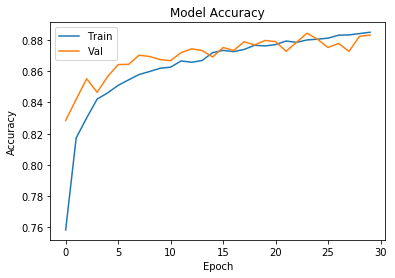

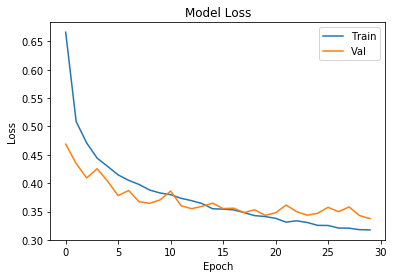

In [16]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_unidad_tanh)

plot_loss(history_unidad_tanh)

## Comparación de las unidades de activación: sigmoid, ReLU, tanh

### Sigmoid

Este modelo no obtuvo muy buenos resultados como los otros dos. Vimos que su velocidad de convergencia fue más lenta. En 30 épocas apenas alcanzó una precisión de 82% y necesitaba más épocas para mejorar este valor. Esto se debe a las características de la función sigmoid, ya que esta tiende a matar los gradientes de las neuronas que tienen valores muy altos o muy bajos en sus parámetros. Las neuronas saturadas con valores extremos tienden a 1 o 0 y aquí sus gradientes son aproximadamente 0.
Esto implica que el gradiente que se propaga hacia atrás se elimine perjudicando el aprendizaje.

### ReLU

En este modelo se mejoraron los resultados del caso anterior. El aprendizaje se aceleró ya que en las mismas 30 épocas se alcanzó una precisión del 88%. Las unidades ReLU no saturan los valores grandes convirtiendolos en 1, esto nos ayuda con el problema de la eliminación del gradiente en el régimen positivo de las neuronas. En otras palabras tendríamos menos neuronas que mueren en el entrenamiento. Además, con esta unidad le ahorramos a nuestra computadora el proceso de calcular exponenciales, y en su lugar usamos la función identidad.
La desventaja en este modelo fue que empezamos a caer en overfitting desde la época 15. Esto nos lleva a pensar en que debemos tener cuidado con el valor de learning rate.

### Tanh

En este modelo se obtuvieron muy buenos resultados ya que se llegó a una precisión de 88% con datos de validación en 30 épocas. Este modelo no mata muchos gradientes como lo hacía la unidad sigmoid, debido a que se amplia el régimen de saturación desde -1 a 1. Sin embargo, observamos que la curva de precisión es muy oscilante debido a que todavía tenemos muerte de gradientes en el entrenameinto aunque en menor cantidad.

En conclusión, en la siguiente figura observamos que la unidad de activación ReLU es la más efectiva para este modelo y la que menos pérdidad genera. Además tiene mayor velocidad de convergencia frente a las otras dos unidades de activación.

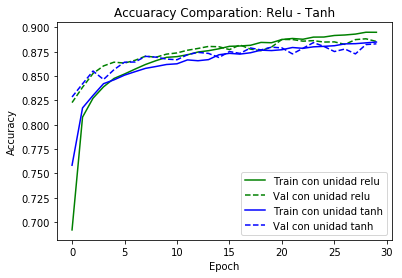

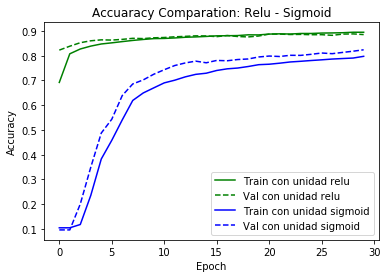

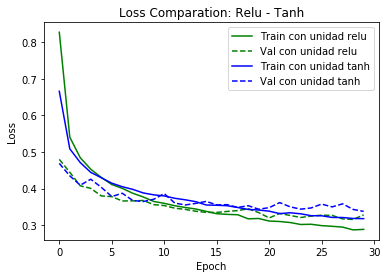

In [17]:
# Se realizan los gráficos de comparación en la precisión y el error de los modelos

plot_compare_accs(history_unidad_relu, history_unidad_tanh, name1="con unidad relu",
                        name2="con unidad tanh", title="Accuaracy Comparation: Relu - Tanh")

plot_compare_accs(history_unidad_relu, history_unidad_sigmoid, name1="con unidad relu",
                        name2="con unidad sigmoid", title="Accuaracy Comparation: Relu - Sigmoid")

plot_compare_losses(history_unidad_relu, history_unidad_tanh, name1="con unidad relu",
                        name2="con unidad tanh", title="Loss Comparation: Relu - Tanh")

## 2. Inicialización de parámetros

En este ejercicio, vamos a evaluar la importancia de una correcta inicialización de parámetros en una red neuronal.

**Ejercicio 2**: Partiendo de una red similar a la del ejercicio anterior (usando ya ReLUs), comentar las diferencias que se aprecian en el entrenamiento al utilizar distintas estrategias de inicialización de parámetros. Para ello, inicializar todas las capas con las siguientes estrategias, disponibles en Keras, y analizar sus diferencias:

* Inicialización con ceros.
* Inicialización con una variable aleatoria normal.
* Inicialización con los valores por defecto de Keras para una capa Dense (estrategia *glorot uniform*)

## Inicialización con Ceros

A continuación se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí vamos a ver el efecto que tiene la inicialización de los pesos y biases en cero. Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes métodos de inicialización.

In [18]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [19]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 20

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con un inicializador de pesos (kernel_initializer) y biases (bias_initializer='zeros') en ceros.
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, kernel_initializer='zeros', bias_initializer='zeros', activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='zeros', bias_initializer='zeros', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='zeros', bias_initializer='zeros', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='zeros', bias_initializer='zeros', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='zeros', bias_initializer='zeros', activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               10100     
__________

In [20]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)

sgd = optimizers.SGD(lr=0.09, decay=1e-6, momentum=0.0, nesterov=True)

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_initializer_zero = model.fit(x_train, y_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      verbose=1,
                                      validation_split=0.2
                                     )

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 110us/step - loss: 2.3030 - acc: 0.0995 - val_loss: 2.3030 - val_acc: 0.1003
Epoch 2/20
48000/48000 [==============================] - 5s 100us/step - loss: 2.3031 - acc: 0.0989 - val_loss: 2.3028 - val_acc: 0.1003
Epoch 3/20
48000/48000 [==============================] - 5s 101us/step - loss: 2.3031 - acc: 0.0967 - val_loss: 2.3026 - val_acc: 0.1003
Epoch 4/20
48000/48000 [==============================] - 5s 101us/step - loss: 2.3030 - acc: 0.0973 - val_loss: 2.3031 - val_acc: 0.1027
Epoch 5/20
48000/48000 [==============================] - 5s 99us/step - loss: 2.3030 - acc: 0.1000 - val_loss: 2.3029 - val_acc: 0.1027
Epoch 6/20
48000/48000 [==============================] - 5s 99us/step - loss: 2.3030 - acc: 0.1010 - val_loss: 2.3034 - val_acc: 0.1005
Epoch 7/20
48000/48000 [==============================] - 5s 96us/step - loss: 2.3030 - acc: 0.0975 - val_loss: 2.3028 - val

### Observaciones

Podemos observar en los gráficos de precisión y pérdidas que los valores del conjunto de validación y de train son muy aleatorios oscilando entre 0% y 2% de precisión. Es decir, la red no está aprendiendo nada. Esto se debe a que cuando inicializamos los parámetros en ceros, todas las neuronas tienen la misma salida 0; y por lo tanto, todas las neuronas tendrían el mismo gradiente 0.

Como vemos es un error iniciar los pesos y biases en ceros en una red neuronal.

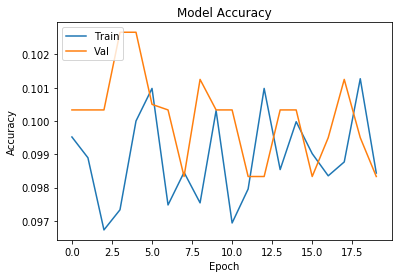

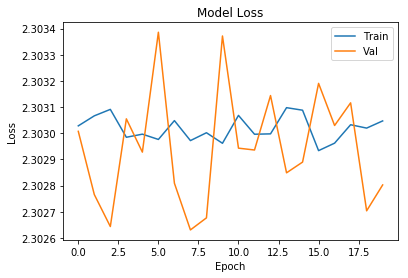

In [21]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_initializer_zero)

plot_loss(history_initializer_zero)

## Inicialización con una variable aleatoria normal

A continuación se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí vamos a ver el efecto que tiene la inicialización de los pesos y biases con una variable aleatoria normal. Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes métodos de inicialización.

In [22]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [23]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 20

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con inicialización de pesos y biases de tipo random_normal
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, kernel_initializer='random_normal', bias_initializer='random_normal', activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='random_normal', bias_initializer='random_normal', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='random_normal', bias_initializer='random_normal', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='random_normal', bias_initializer='random_normal', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='random_normal', bias_initializer='random_normal', activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               10100     
__________

In [24]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)

sgd = optimizers.SGD(lr=0.09, decay=1e-6, momentum=0.0, nesterov=True)

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_initializer_random_normal = model.fit(x_train, y_train,
                                          batch_size=batch_size,
                                          epochs=epochs,
                                          verbose=1,
                                          validation_split=0.2
                                         )

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 108us/step - loss: 1.2693 - acc: 0.4978 - val_loss: 0.6863 - val_acc: 0.7090
Epoch 2/20
48000/48000 [==============================] - 5s 99us/step - loss: 0.6598 - acc: 0.7454 - val_loss: 0.6037 - val_acc: 0.7537
Epoch 3/20
48000/48000 [==============================] - 5s 97us/step - loss: 0.5530 - acc: 0.7952 - val_loss: 0.4714 - val_acc: 0.8257
Epoch 4/20
48000/48000 [==============================] - 5s 96us/step - loss: 0.4907 - acc: 0.8235 - val_loss: 0.4270 - val_acc: 0.8427
Epoch 5/20
48000/48000 [==============================] - 5s 96us/step - loss: 0.4576 - acc: 0.8373 - val_loss: 0.4209 - val_acc: 0.8482
Epoch 6/20
48000/48000 [==============================] - 5s 96us/step - loss: 0.4326 - acc: 0.8467 - val_loss: 0.3747 - val_acc: 0.8648
Epoch 7/20
48000/48000 [==============================] - 5s 96us/step - loss: 0.4135 - acc: 0.8519 - val_loss: 0.3665 - val_ac

### Observaciones

Podemos observar que en este modelo tenemos mejores resultados de precisión y pérdidas con respecto al modelo anterior. La inicialización aleatoria de pesos y biases generan asimetría lo que evita que los gradientes se eliminen.

Sin embargo, cuando volvemos a entrenar la red podemos darnos cuenta que la precisión puede disminuir o aumentar en una pequeña medida. En este modelo NO se nota mucho este efecto pero en redes neuronales muy profundas la inicialización de parámetros de este tipo generan valores muy pequeños y los gradientes tienden a 0, creando conflictos en el aprendizaje.

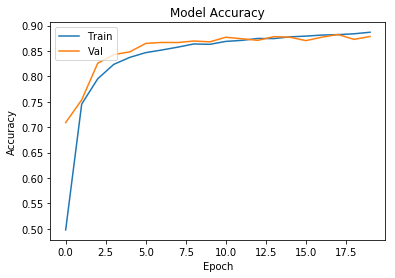

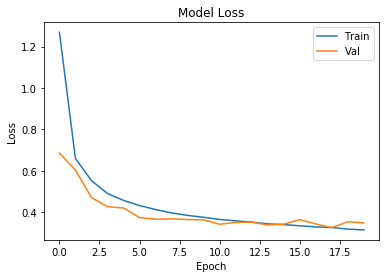

In [25]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_initializer_random_normal)

plot_loss(history_initializer_random_normal)

## Inicialización con los valores por defecto de Keras para una capa Dense (estrategia glorot uniform o Xavier Initialization)

A continuación se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí vamos a ver el efecto que tiene la inicialización de los pesos y biases con valores por defecto (Glorot Uniform o Xavier Initialization). Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes métodos de inicialización.

In [26]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [27]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 20

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con inicializador de pesos y biases de tipo glorot_uniform o Xavier Initialization
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_22 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               10100     
__________

In [28]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)

sgd = optimizers.SGD(lr=0.09, decay=1e-6, momentum=0.0, nesterov=True)

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_initializer_glorot_uniform = model.fit(x_train, y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_split=0.2
                                 )

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 6s 119us/step - loss: 0.8210 - acc: 0.6945 - val_loss: 0.4962 - val_acc: 0.8153
Epoch 2/20
48000/48000 [==============================] - 5s 102us/step - loss: 0.5562 - acc: 0.8022 - val_loss: 0.4702 - val_acc: 0.8187
Epoch 3/20
48000/48000 [==============================] - 5s 99us/step - loss: 0.4953 - acc: 0.8243 - val_loss: 0.4316 - val_acc: 0.8427
Epoch 4/20
48000/48000 [==============================] - 5s 99us/step - loss: 0.4598 - acc: 0.8368 - val_loss: 0.3966 - val_acc: 0.8573
Epoch 5/20
48000/48000 [==============================] - 5s 99us/step - loss: 0.4356 - acc: 0.8460 - val_loss: 0.3986 - val_acc: 0.8542
Epoch 6/20
48000/48000 [==============================] - 5s 98us/step - loss: 0.4192 - acc: 0.8488 - val_loss: 0.3786 - val_acc: 0.8614
Epoch 7/20
48000/48000 [==============================] - 5s 104us/step - loss: 0.4073 - acc: 0.8539 - val_loss: 0.3792 - val_

### Observaciones

En este modelo podemos observar que se alcanza la mayor precisión de 88% con respecto a los modelos anteriores. El modelo con Xavier Initialization genera una curva de precisión un poco oscilante al principio pero que se va estabilizando. Esto puede darse porque al principio se establecen valores aleatorios tratando que la varianza de salida de las neuronas sea igual a la varianza de entrada. Estos valores se van ajustando con el aprendizaje. Con Xavier Initialization solucionamos el problema de valores pequeños que generan gradientes 0.

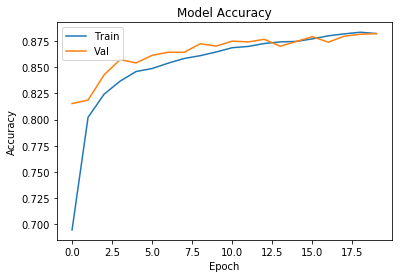

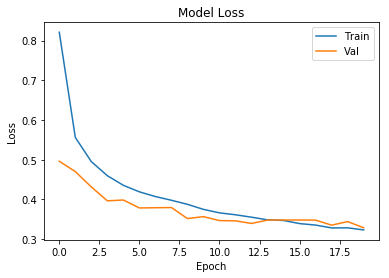

In [29]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_initializer_glorot_uniform)

plot_loss(history_initializer_glorot_uniform)

## Comparación de los inicializadores de parámetros

Como podemos observar en los gráficos de precisión y error, la inicialización glorot uniform es la más efectiva. Soluciona el problema de las dos inicializaciones anteriores tratando de que los gradientes no sean 0.

#### Inicialización con ceros

Precisión en validación: 10%
Loss en validación: 200%
Épocas: 20

#### Inicialización random normal

Precisión en validación: 88%
Loss en validación: 33%
Épocas: 20

#### Inicialización con glorot uniform (Xavier Initialization)

Precisión en validación: 88%
Loss en validación: 32%
Épocas: 20

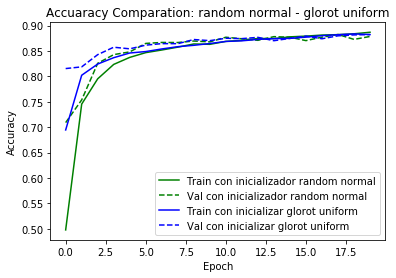

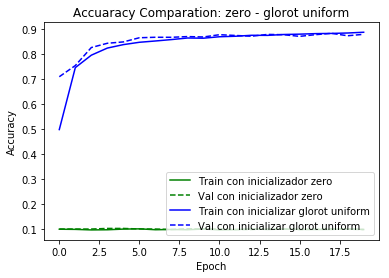

In [30]:
# Se realizan los gráficos de comparación en la precisión de los modelos

plot_compare_accs(history_initializer_random_normal, history_initializer_glorot_uniform, name1="con inicializador random normal",
                        name2="con inicializar glorot uniform", title="Accuaracy Comparation: random normal - glorot uniform")

plot_compare_accs(history_initializer_zero, history_initializer_random_normal, name1="con inicializador zero",
                        name2="con inicializar glorot uniform", title="Accuaracy Comparation: zero - glorot uniform")

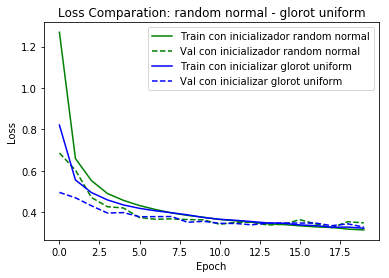

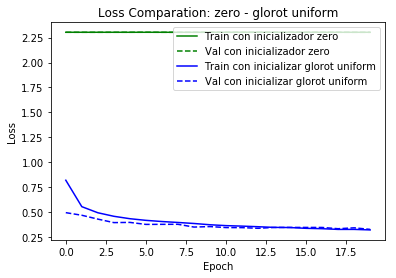

In [31]:
# Se realizan los gráficos de comparación en el error de los modelos

plot_compare_losses(history_initializer_random_normal, history_initializer_glorot_uniform, name1="con inicializador random normal",
                        name2="con inicializar glorot uniform", title="Loss Comparation: random normal - glorot uniform")

plot_compare_losses(history_initializer_zero, history_initializer_glorot_uniform, name1="con inicializador zero",
                        name2="con inicializar glorot uniform", title="Loss Comparation: zero - glorot uniform")

## 3. Optimizadores

**Ejercicio 3**: Partiendo de una red similar a la del ejercicio anterior (utilizando la mejor estrategia de inicialización observada), comparar y analizar las diferencias que se observan  al entrenar con varios de los optimizadores vistos en clase, incluyendo SGD como optimizador básico (se puede explorar el espacio de hiperparámetros de cada optimizador, aunque para optimizadores más avanzados del estilo de adam y RMSprop es buena idea dejar los valores por defecto provistos por Keras).

## Con SDG

A continuación se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí vamos a ver el efecto que tiene la utilización del optimizador SDG (Stochastic gradient descent). Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes optimizadores.

In [32]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [33]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 20

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_26 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_27 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               10100     
__________

In [34]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)
# Los parámetros utilizados son:
                    #lr: learning rate
                    #decay: hace que el valor de learning rate descienda cada época en función del factor dado.
                    #momentum: Es como un vector de velocidad que guarda la media ponderada de gradientes anteriores. 
                    #          Sirve para no quedarse en puntos sila o no quedarse en falsos mínimos.
                    #nesterov: Es una variante más moderna al SDG momentum. Aplica el gradiente sobre el update que hace
                    #          el vector de velocidad.

sgd = optimizers.SGD(lr=0.09, decay=1e-6, momentum=0.0, nesterov=True)

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=sgd,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_optimizador_sdg = model.fit(x_train, y_train,
                                  batch_size=batch_size,
                                  epochs=epochs,
                                  verbose=1,
                                  validation_split=0.2
                                 )

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 6s 117us/step - loss: 0.8440 - acc: 0.6823 - val_loss: 0.5049 - val_acc: 0.8171
Epoch 2/20
48000/48000 [==============================] - 5s 99us/step - loss: 0.5561 - acc: 0.8027 - val_loss: 0.4299 - val_acc: 0.8436
Epoch 3/20
48000/48000 [==============================] - 5s 98us/step - loss: 0.4985 - acc: 0.8226 - val_loss: 0.4255 - val_acc: 0.8427
Epoch 4/20
48000/48000 [==============================] - 5s 99us/step - loss: 0.4623 - acc: 0.8363 - val_loss: 0.3903 - val_acc: 0.8599
Epoch 5/20
48000/48000 [==============================] - 5s 99us/step - loss: 0.4423 - acc: 0.8430 - val_loss: 0.3828 - val_acc: 0.8609
Epoch 6/20
48000/48000 [==============================] - 5s 101us/step - loss: 0.4204 - acc: 0.8499 - val_loss: 0.3792 - val_acc: 0.8609
Epoch 7/20
48000/48000 [==============================] - 5s 100us/step - loss: 0.4089 - acc: 0.8551 - val_loss: 0.3698 - val_

### Observaciones

En este modelo obtuvimos mejores resultados al usar el optimizador SDG con Nesterov Momentum. El SDG normal tiene problemas en la práctica:

        - El coste o loss disminuye rápidamente en una dirección y muy lento en otra. Esto relentisa el aprendizaje.
        - La presencia de mínimos locales que no son los mínimos globales en la función.
        - Quedarse en puntos de silla donde su derivada es cero.
        
Por este motivo utilizamos las variantes de SDG como SDG + momentum y Nesterov momentum. Estas variantes le dan velocidad al descenso del coste y evita quedarse parado en punto de silla o mínimos locales. En este modelo nos dio mejores resultados utilizar nesterov momentum llegando a tener una precisión del 88.4% en datos de validación y poco sobreajuste de datos como podemos ver en el siguiente gráfico.

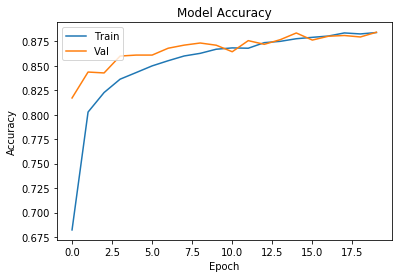

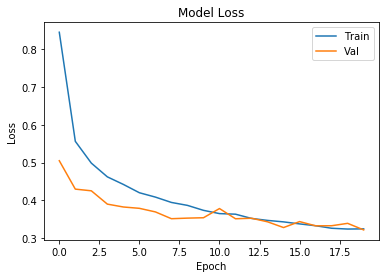

In [35]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_optimizador_sdg)

plot_loss(history_optimizador_sdg)

## AdaGrad

A continuación se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí vamos a ver el efecto que tiene la utilización del optimizador AdaGrad. Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes optimizadores.

In [36]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [37]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 20

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_30 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 100)               10100     
__________

In [38]:
# Se utiliza AdaGrad como optimizador de la red
# Se recomienda dejar los parámetros de este optimizador por defecto

adagrad = optimizers.Adagrad()

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adagrad,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_optimizador_adagrad = model.fit(x_train, y_train,
                                          batch_size=batch_size,
                                          epochs=epochs,
                                          verbose=1,
                                          validation_split=0.2
                                         )

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 6s 117us/step - loss: 0.7165 - acc: 0.7350 - val_loss: 0.4580 - val_acc: 0.8308
Epoch 2/20
48000/48000 [==============================] - 5s 104us/step - loss: 0.5062 - acc: 0.8200 - val_loss: 0.4138 - val_acc: 0.8485
Epoch 3/20
48000/48000 [==============================] - 5s 108us/step - loss: 0.4652 - acc: 0.8350 - val_loss: 0.3922 - val_acc: 0.8552
Epoch 4/20
48000/48000 [==============================] - 5s 102us/step - loss: 0.4368 - acc: 0.8434 - val_loss: 0.3855 - val_acc: 0.8608
Epoch 5/20
48000/48000 [==============================] - 5s 102us/step - loss: 0.4185 - acc: 0.8506 - val_loss: 0.3739 - val_acc: 0.8632
Epoch 6/20
48000/48000 [==============================] - 5s 101us/step - loss: 0.4089 - acc: 0.8540 - val_loss: 0.3676 - val_acc: 0.8640
Epoch 7/20
48000/48000 [==============================] - 5s 100us/step - loss: 0.3939 - acc: 0.8599 - val_loss: 0.3587 - 

### Observaciones

El optimizador AdaGrad modifica el learning rate de manera independiente por cada parámetro. Si el valor del gradiente es grande hacemos que el avance en esa dirección sea reducido y si el valor del gradiente es pequeño hacemos que el avance sea amplificado.

En este modelo obtuvimos una precisión del 88% en datos de validación. Como vemos en los siguientes gráficos no hay sobreajuste y la curva de precisión avanza bien. 

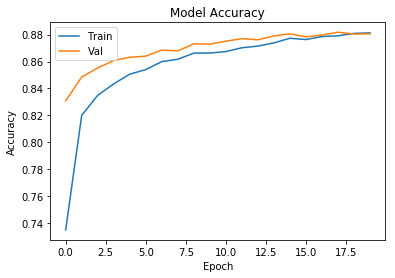

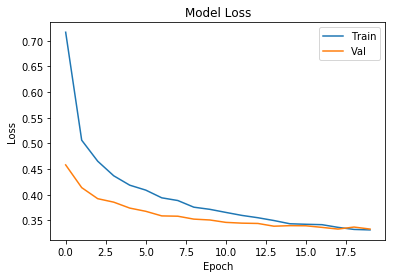

In [39]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_optimizador_adagrad)

plot_loss(history_optimizador_adagrad)

## Con RMSprop

A continuación se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí vamos a ver el efecto que tiene la utilización del optimizador RMSprop. Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes optimizadores.

In [40]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [41]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 20

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 100)               10100     
__________

In [42]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)

rmsprop = optimizers.RMSprop()

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=rmsprop,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_optimizador_rmsprop = model.fit(x_train, y_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      verbose=1,
                                      validation_split=0.2
                                     )

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 6s 125us/step - loss: 0.7006 - acc: 0.7439 - val_loss: 0.4704 - val_acc: 0.8291
Epoch 2/20
48000/48000 [==============================] - 6s 115us/step - loss: 0.4901 - acc: 0.8247 - val_loss: 0.4060 - val_acc: 0.8548
Epoch 3/20
48000/48000 [==============================] - 5s 108us/step - loss: 0.4469 - acc: 0.8434 - val_loss: 0.4119 - val_acc: 0.8486
Epoch 4/20
48000/48000 [==============================] - 5s 107us/step - loss: 0.4216 - acc: 0.8529 - val_loss: 0.4036 - val_acc: 0.8622
Epoch 5/20
48000/48000 [==============================] - 5s 105us/step - loss: 0.4103 - acc: 0.8572 - val_loss: 0.3718 - val_acc: 0.8717
Epoch 6/20
48000/48000 [==============================] - 5s 106us/step - loss: 0.3972 - acc: 0.8619 - val_loss: 0.3586 - val_acc: 0.8752
Epoch 7/20
48000/48000 [==============================] - 5s 105us/step - loss: 0.3931 - acc: 0.8652 - val_loss: 0.4003 - 

### Observaciones

El método RMSprop elabora las ideas de AdaGrad. RMSprop en vez de sumar los cuadrados de los gradientes, introduce un decay, de manera que los valores no se acumulen y evitando que el entrenamiento se pare en cierto momento.

En este modelo se obtuvo una precisión del 88% en datos de validación pero observamos que la curva de precisión es más oscilante que cuando utilizamos AdaGrad.

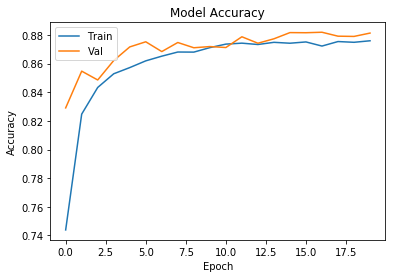

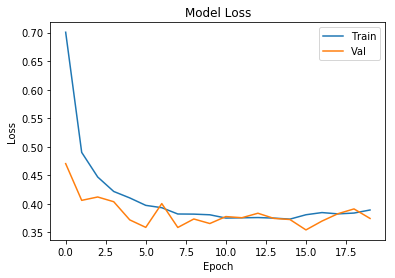

In [43]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_optimizador_rmsprop)

plot_loss(history_optimizador_rmsprop)

## Con Adam

A continuación se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí vamos a ver el efecto que tiene la utilización del optimizador Adam. Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes optimizadores.

In [44]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [45]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 20

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_37 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_38 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_39 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               10100     
__________

In [46]:
# Se utiliza Adam como optimizador de la red
# Se recomienda dejar los parámetros de este optimizador por defecto

adam = optimizers.Adam()

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adam,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_optimizador_Adam = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2
         )

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 5s 103us/step - loss: 0.7363 - acc: 0.7327 - val_loss: 0.4499 - val_acc: 0.8321
Epoch 2/20
48000/48000 [==============================] - 4s 89us/step - loss: 0.4848 - acc: 0.8277 - val_loss: 0.4153 - val_acc: 0.8522
Epoch 3/20
48000/48000 [==============================] - 4s 82us/step - loss: 0.4396 - acc: 0.8434 - val_loss: 0.3967 - val_acc: 0.8546
Epoch 4/20
48000/48000 [==============================] - 4s 84us/step - loss: 0.4130 - acc: 0.8523 - val_loss: 0.3869 - val_acc: 0.8571
Epoch 5/20
48000/48000 [==============================] - 4s 86us/step - loss: 0.3935 - acc: 0.8595 - val_loss: 0.3632 - val_acc: 0.8681
Epoch 6/20
48000/48000 [==============================] - 4s 83us/step - loss: 0.3809 - acc: 0.8633 - val_loss: 0.3520 - val_acc: 0.8748
Epoch 7/20
48000/48000 [==============================] - 5s 107us/step - loss: 0.3688 - acc: 0.8681 - val_loss: 0.3524 - val_a

### Observaciones

El método de optimización Adam utiliza una combinación de RMSprop con momentum. Vemos que utilizando este optimizador llegamos a tener 88.17% de precisión en datos de validación. 

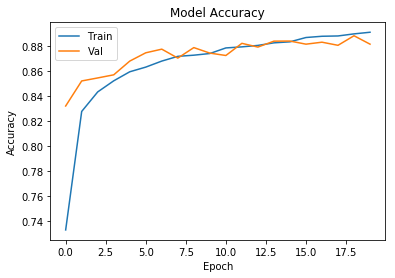

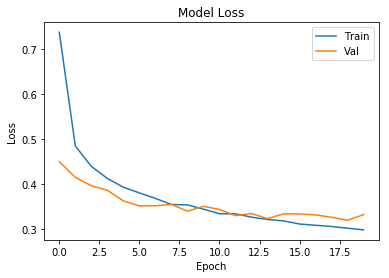

In [47]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_optimizador_Adam)

plot_loss(history_optimizador_Adam)

## Con Adamax

A continuación se entrena una red neuronal de 4 capas ocultas, densas y con 100 neuronas cada una. Aquí vamos a ver el efecto que tiene la utilización del optimizador Adamax. Veremos qué precisión tiene el modelo y la compararemos con otros modelos usando diferentes optimizadores.

In [48]:
# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [49]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 20

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_41 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_42 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_43 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 100)               10100     
__________

In [50]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)

adamax = optimizers.Adamax()

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adamax,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_optimizador_adamax = model.fit(x_train, y_train,
                                      batch_size=batch_size,
                                      epochs=epochs,
                                      verbose=1,
                                      validation_split=0.2
                                     )

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 6s 123us/step - loss: 0.7874 - acc: 0.7096 - val_loss: 0.4688 - val_acc: 0.8295
Epoch 2/20
48000/48000 [==============================] - 5s 104us/step - loss: 0.5211 - acc: 0.8157 - val_loss: 0.4100 - val_acc: 0.8488
Epoch 3/20
48000/48000 [==============================] - 5s 113us/step - loss: 0.4611 - acc: 0.8361 - val_loss: 0.3946 - val_acc: 0.8566
Epoch 4/20
48000/48000 [==============================] - 5s 109us/step - loss: 0.4354 - acc: 0.8457 - val_loss: 0.3783 - val_acc: 0.8601
Epoch 5/20
48000/48000 [==============================] - 5s 106us/step - loss: 0.4122 - acc: 0.8523 - val_loss: 0.3798 - val_acc: 0.8639
Epoch 6/20
48000/48000 [==============================] - 5s 103us/step - loss: 0.3944 - acc: 0.8573 - val_loss: 0.3688 - val_acc: 0.8665
Epoch 7/20
48000/48000 [==============================] - 5s 107us/step - loss: 0.3834 - acc: 0.8644 - val_loss: 0.3623 - 

### Observaciones

Adamax es una variante de Adam basado en la norma infinita. En este modelo observamos que tenemos una precisión de 88.5% en datos de validación.

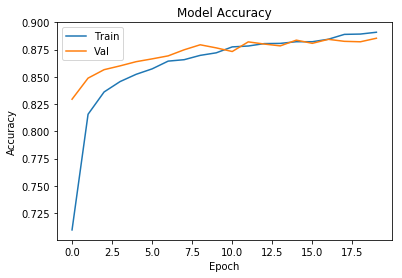

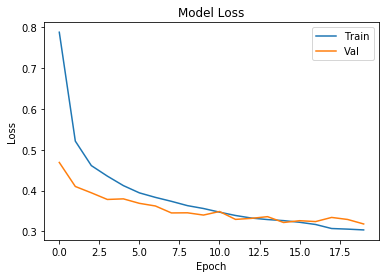

In [51]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_optimizador_adamax)

plot_loss(history_optimizador_adamax)

## Comparación de los optimizadores

Como podemos observar en los gráficos de precisión y error, la utilización de los optimizadores SDG, Adagrad, Adam y Adamax son los más efectiva para este modelo. Estos optmizadores hacen que el modelo converja con mayor rapidez y menor pérdida. 

**Optimizador SDG**

Precisión en validación: 89%

Loss en validación: 32% 

Épocas: 20

**Optimizador Adagrad**

Precisión en validación: 88% 

Loss en validación: 33% 

Épocas: 20

**Optimizador RMSprop**

Precisión en validación: 88% 

Loss en validación: 39% 

Épocas: 20

**Optimizador Adam**

Precisión en validación: 88% 

Loss en validación: 32% 

Épocas: 20

**Optimizador Adamax**

Precisión en validación: 89% 

Loss en validación: 32% 

Épocas: 20

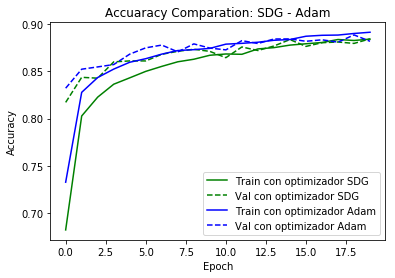

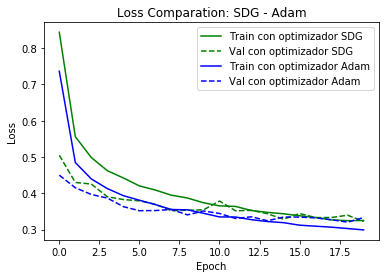

In [52]:
# Se realizan los gráficos de comparación en la precisión de los modelos

plot_compare_accs(history_optimizador_sdg, history_optimizador_Adam, name1="con optimizador SDG",
                        name2="con optimizador Adam", title="Accuaracy Comparation: SDG - Adam")

plot_compare_losses(history_optimizador_sdg, history_optimizador_Adam, name1="con optimizador SDG",
                        name2="con optimizador Adam", title="Loss Comparation: SDG - Adam")

## 4. Regularización y red final

**Ejercicio 4.1**: Entrenar una red final que sea capaz de obtener una accuracy en el validation set cercana al 90%. Para ello, combinar todo lo aprendido anteriormente y utilizar técnicas de regularización para evitar overfitting. Algunos de los elementos que pueden tenerse en cuenta son los siguientes.

* Número de capas y neuronas por capa
* Optimizadores y sus parámetros
* Batch size
* Unidades de activación
* Uso de capas dropout, regularización L2, regularización L1...
* Early stopping (se puede aplicar como un callback de Keras, o se puede ver un poco "a ojo" cuándo el modelo empieza a caer en overfitting y seleccionar el número de epochs necesarias)
* Batch normalization

Si los modelos entrenados anteriormente ya se acercaban al valor requerido de accuracy, probar distintas estrategias igualmente y comentar los resultados.

Explicar brevemente la estrategia seguida y los modelos probados para obtener el modelo final, que debe verse entrenado en este Notebook. No es necesario guardar el entrenamiento de todos los modelos que se han probado, es suficiente con explicar cómo se ha llegado al modelo final.

### Creación de la red neuronal

A continuación se entrena la red neuronal con los mejores resultados obtenidos. Sus características son las siguientes: 

    - 4 capas ocultas de 100 neuronas cada una.
    - Dropout(0.2) para regularización en todas las capas.
    - Glorot uniform como inicializador de pesos y biases.
    - Las unidades de activación en todas las capas es ReLU.
    - La última capa es de tipo softmax para representar las clases como funciones de probabilidad.
    - Para optimizar el entrenamiento utilizamos el método Adam.
    - La última capa es de tipo softmax.

In [53]:
## Tu modelo y comentarios de texto aquí
## Puedes incluir tantas celdas como quieras
## No olvides utilizar celdas de Markdown para texto

# Se crean los conjuntos de train y test a partir de los datos de fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Se normalizan los datos en valores entre 0 y 1

x_train = x_train / 255.0
x_test = x_test / 255.0

# Se preparan los datos de train y test para que sean compatibles con keras
# Primero se define el tamaño de los arrays
# Después de transforma el tipo de dato a float para que funcionen en Keras

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [54]:
# Se definen las caratacterísticas de la red neuronal para el proceso de entrenamiento.

batch_size = 64
num_classes = 10
epochs = 20

# Se convierten los conjuntos train y test que contienen las clases, a tipo categóricas

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Se crea la arquitectura de la red neuronal
# Con 784 (28x28) inputs que provienen de cada píxel de las imágenes
# Con 4 capas ocultas de 100 neuronas
# Con funciones de activación ReLU
# Con Dropout() para regularizar el modelo y ayudar a la red a evitar el sobreajuste de los datos
# Con la última capa de tipo softmax para representarlos como funciones de probabilidad

model = Sequential()
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform', activation='softmax'))

# Se observa una descripción de la arquitectura de la red neuronal

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout_45 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_46 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_47 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 100)               10100     
__________

In [55]:
# Se utiliza como optimizador de la red el sdg (stochastic gradient descent)

adagrad = optimizers.adagrad()

# Se compila el modelo para la red neuronal. Se establece que la métrica de evaluación sea la exactitud (accuracy)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=adagrad,
              metrics=['accuracy'])

# Se entrena la red neuronal y se observa en pantalla los resultados de loss y accuracy por cada epoch
# Con el parámetro validation_split=0.2 estamos separando un 20% de conjunto de validación a partir del conjunto de train.

history_optimizador_final = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.2
         )

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 6s 121us/step - loss: 0.6834 - acc: 0.7472 - val_loss: 0.4473 - val_acc: 0.8371
Epoch 2/20
48000/48000 [==============================] - 5s 103us/step - loss: 0.5003 - acc: 0.8240 - val_loss: 0.4107 - val_acc: 0.8494
Epoch 3/20
48000/48000 [==============================] - 5s 103us/step - loss: 0.4584 - acc: 0.8398 - val_loss: 0.3845 - val_acc: 0.8578
Epoch 4/20
48000/48000 [==============================] - 5s 104us/step - loss: 0.4337 - acc: 0.8465 - val_loss: 0.3774 - val_acc: 0.8628
Epoch 5/20
48000/48000 [==============================] - 5s 106us/step - loss: 0.4144 - acc: 0.8537 - val_loss: 0.3643 - val_acc: 0.8688
Epoch 6/20
48000/48000 [==============================] - 5s 109us/step - loss: 0.4004 - acc: 0.8575 - val_loss: 0.3614 - val_acc: 0.8703
Epoch 7/20
48000/48000 [==============================] - 5s 111us/step - loss: 0.3884 - acc: 0.8619 - val_loss: 0.3573 - 

### Observaciones

Podemos observar que nuestro modelo alcanza una precisión del 88.6% con datos de validación y un 32% de coste. En la curva de precisión vemos que no caemos en overfitting ni tampoco tiene un comportamiento oscilante. 

La última capa utiliza una función softmax que normaliza las salidas entre 0 y 1 asignando probabilidades decimales a cada clase en un caso de clases múltiples. Estas probabilidades suman 1. Se utiliza en problemas de clases excluyentes o en donde solo una clase es posible.Es decir, la salida es una distrubución de probabilidad con los valores de probabilidad de cada clase.

El modelo se entrena perfectamente con 20 épocas antes de caer en sobre ajuste. A partir de este valor vimos que las curvas de precisión se cruzan.
    

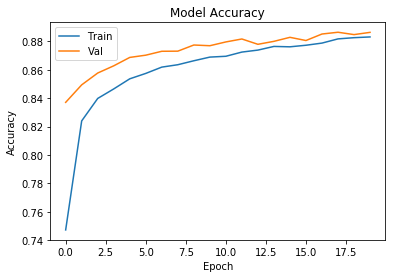

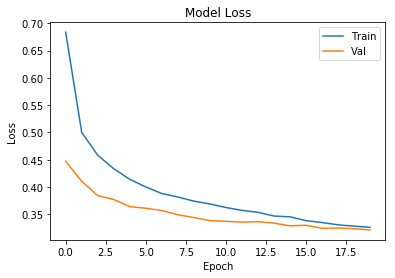

In [56]:
# Se realizan los gráficos de la precisión y el error en el modelo

plot_acc(history_optimizador_final)

plot_loss(history_optimizador_final)

### Evaluación del modelo en datos de test

Una vez elegido el que creemos que es nuestro mejor modelo a partir de la estimación que hemos visto en los datos de validación, es hora de utilizar los datos de test para ver cómo se comporta nuestro modelo ante nuevos datos. Si hemos hecho bien las cosas, este número debería ser parecido al valor de nuestra estimación vista en los datos de validación.

**Pregunta 4.2**. Utilizando nuestro mejor modelo, obtener la accuracy resultante en el dataset de test. Comentar este resultado.

In [57]:
## Tu código y comentarios de texto aquí

# Para obtener el accuracy resultante utilizamos la función evaluate() de keras.
# Se aplica la función sobre los conjuntos de test

score = model.evaluate(x_test, y_test, verbose=0)

# Se imprime en pantalla los resultados del modelo

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35307243392467497
Test accuracy: 0.8747


### Conclusiones

Podemos observar que nuestro modelo obtiene una precisión del 87% en datos de test. Esta es una medida aceptable puesto que en datos de validación se obtuvo un 88% de precisión.

Para llegar a este resultado se probó entre varios modelos, modificando los parámetros de diversas funciones como de los optimizadores. Se probaron varias topologías de red y elegimos la que nos brinda mayor velocidad de convergencia y mejores resultados de precisión.